# Coursework for MRI reconstruction (Autumn 2019)

In this tutorial, we provide the data loader to read and process the MRI data in order to ease the difficulty of training your network. By providing this, we hope you focus more on methodology development. Please feel free to change it to suit what you need.

In [1]:
import h5py, os
from functions import transforms as T
from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [3]:
class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]

        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)

In [4]:
def get_epoch_batch(subject_id, acc, center_fract, use_seed=True):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)
    
    
    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
    
#    img_gt = T.center_crop(T.complex_abs(img_gt), [320, 320]).unsqueeze(1)
#    img_und = T.center_crop(T.complex_abs(img_und), [320, 320]).unsqueeze(1)
#     rawdata_und = T.center_crop(T.complex_abs(rawdata_und), [320, 320]).unsqueeze(1)
#     norm = T.center_crop(T.complex_abs(norm), [320, 320]).unsqueeze(1)
#     masks.T.center_crop(T.complex_abs(masks), [320, 320]).unsqueeze(1)    

    img_gt = T.center_crop(T.complex_abs(img_gt), [320, 320])
    img_und = T.center_crop(T.complex_abs(img_und), [320, 320])
        
    return img_gt.squeeze(0), img_und.squeeze(0)


In [5]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
    
        for fname in sorted(os.listdir(which_data_path)):
            
            subject_data_path = os.path.join(which_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
    
    return data_list    

In [6]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), #320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), #320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(128 ,256, kernel_size=3, padding=1),  # 320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1), #320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # 320/320
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),  # 320/320
            
            
        )

    def forward(self, x):
        x = self.features(x)
        #x = nn.functional.sigmoid(x)
        #x = x * 255
        #x = x.type(torch.cuda.int32)
        return x

In [7]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [8]:
class baseBlock(torch.nn.Module):
    expansion = 1
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(baseBlock,self).__init__()
        #declare convolutional layers with batch norms
        self.conv1 = torch.nn.Conv2d(input_planes,planes,stride=stride,kernel_size=3,padding=1)
        self.bn1   = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
        self.bn2   = torch.nn.BatchNorm2d(planes)
        self.dim_change = dim_change
    def forward(self,x):
        #Save the residue
        res = x
        #output = F.relu(self.conv1(x))
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        #output = self.conv2(output)
        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)

        return output

class bottleNeck(torch.nn.Module):
    expansion = 4
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(bottleNeck,self).__init__()

        self.conv1 = torch.nn.Conv2d(input_planes,planes,kernel_size=1,stride=1)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,kernel_size=3,stride=stride,padding=1)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.conv3 = torch.nn.Conv2d(planes,planes*self.expansion,kernel_size=1)
        self.bn3 = torch.nn.BatchNorm2d(planes*self.expansion)
        self.dim_change = dim_change
    
    def forward(self,x):
        res = x
        
        output = F.relu(self.bn1(self.conv1(x)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.bn3(self.conv3(output))

        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)
        return output

class ResNet(torch.nn.Module):
    def __init__(self,block,num_layers,classes=10):
        super(ResNet,self).__init__()
        #according to research paper:
        self.input_planes = 64
        self.conv1 = torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
        #self.bn1   = torch.nn.BatchNorm2d(64)
        self.layer1 = self._layer(block,64,num_layers[0],stride=1)
        self.layer2 = self._layer(block,64,num_layers[1],stride=1)
        self.layer3 = self._layer(block,64,num_layers[2],stride=1)
        self.layer4 = self._layer(block,64,num_layers[3],stride=1)
        self.layer5 = self._layer(block,64,num_layers[3],stride=1)
        self.layer6 = self._layer(block,64,num_layers[3],stride=1)
        self.layer7 = self._layer(block,64,num_layers[3],stride=1)
        self.layer8 = self._layer(block,64,num_layers[2],stride=1)
        self.layer9 = self._layer(block,64,num_layers[3],stride=1)
        self.layer10 = self._layer(block,64,num_layers[3],stride=1)
        self.layer11 = self._layer(block,64,num_layers[3],stride=1)
        self.layer12 = self._layer(block,64,num_layers[3],stride=1)
        
        #self.conv3 = torch.nn.Conv2d(64,64,kernel_size=3,stride=1, padding=1)
        #self.conv4 = torch.nn.Conv2d(64,64,kernel_size=3,stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(64,1,kernel_size=3,stride=1, padding=1)
        
    
    def _layer(self,block,planes,num_layers,stride=1):
        dim_change = None
        if stride!=1 or planes != self.input_planes*block.expansion:
            dim_change = torch.nn.Sequential(torch.nn.Conv2d(self.input_planes,planes*block.expansion,kernel_size=1,stride=stride),
                                             torch.nn.BatchNorm2d(planes*block.expansion))
        netLayers =[]
        netLayers.append(block(self.input_planes,planes,stride=stride,dim_change=dim_change))
        self.input_planes = planes * block.expansion
        for i in range(1,num_layers):
            netLayers.append(block(self.input_planes,planes))
            self.input_planes = planes * block.expansion
        
        return torch.nn.Sequential(*netLayers)

    def forward(self,x):
        #x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        #x = self.conv3(x)
        #x = self.conv4(x)
        x = self.conv3(x)

        return x

In [9]:
from skimage.measure import compare_ssim 
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

In [11]:


if __name__ == '__main__':
    
    data_path_train = '/data/local/NC2019MRI/train'
    data_path_val = '/data/local/NC2019MRI/train'
    data_list = load_data_path(data_path_train, data_path_val) # first load all file names, paths and slices.
    
    acc = 4
    cen_fract = 0.08
    seed = False # random masks for each slice 
    num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
    lr = 5e-3
    
    network = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
    network.to('cuda:0') #move the model on the GPU
    mse_loss = nn.L1Loss().to('cuda:0')
    
    optimizer = optim.Adam(network.parameters(), lr=lr)
    fixed_train_set = []
    for val in data_list['train']:
        if val[2] > 5:
            fixed_train_set.append(val)
    #create data loader for training set. It applies same to validation set as well
    train_dataset = MRIDataset(fixed_train_set, acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=num_workers) 
    
    losses=[]
    mean_loss_list = []
    
    for epoch in range(10):
        i = 0
        for iteration, sample in enumerate(train_loader):
            i += 1
            img_gt, img_und = sample
        
            img_gt = img_gt.unsqueeze(1).to('cuda:0')
            img_und = img_und.unsqueeze(1).to('cuda:0')

            output = network(img_und)       #feedforward
            #output = output.squeeze(1).cpu().detach().numpy()

            loss = mse_loss(output, img_gt)
            #loss = torch.tensor(ssim(img_gt, output)).to('cuda:0')
            #print(loss.item())
            optimizer.zero_grad()       #set current gradients to 0
            loss.backward()      #backpropagate
            optimizer.step()     #update the weights
            mean_loss_list.append(loss.item())
            if i%5 == 0:
                print(np.round(np.mean(mean_loss_list), decimals = 5), "  ", i, "  ", epoch+1)
                mean_loss_list = []
            losses.append(loss.item() * img_gt.size(0))
        #epoch_loss = running_loss / len(train_loader['train'])
        #losses.append(epoch_loss)
        #plt.plot(np.array(loss_values), 'r')
        
#         stack different slices into a volume for visualisation
#         A = masks[...,0].squeeze()
#         B = torch.log(T.complex_abs(rawdata_und) + 1e-9).squeeze()
#         C = T.complex_abs(img_und).squeeze()
#         D = T.complex_abs(img_gt).squeeze()
#         all_imgs = torch.stack([A,B,C,D], dim=0)

#         # from left to right: mask, masked kspace, undersampled image, ground truth
#         show_slices(all_imgs, [0, 1, 2, 3], cmap='gray')
#         plt.pause(1)

#         if iteration >= 0: break  # show 4 random slices
        

3.74952    5    1
1.23724    10    1
0.55153    15    1
0.31653    20    1
0.30987    25    1
0.30328    30    1
0.3249    35    1
0.35459    40    1
0.22235    45    1
0.1535    50    1
0.20223    55    1
0.18435    60    1
0.16446    65    1
0.10188    70    1
0.11124    75    1
0.15028    80    1
0.10541    85    1
0.10495    90    1
0.10644    95    1
0.10574    100    1
0.11157    105    1
0.10308    110    1
0.08679    115    1
0.10191    120    1
0.10104    125    1
0.09076    130    1
0.08322    135    1
0.08121    140    1
0.09158    145    1
0.0901    150    1
0.09547    155    1
0.10949    160    1
0.08301    165    1
0.08641    170    1
0.07293    175    1
0.05919    180    1
0.08815    185    1
0.08861    190    1
0.07224    195    1
0.07542    200    1
0.08733    205    1
0.10221    210    1
0.10013    215    1
0.08132    220    1
0.08306    225    1
0.08127    230    1
0.09743    235    1
0.0869    240    1
0.0718    245    1
0.10971    250    1
0.21785    255    1
0.128

0.05148    2020    1
0.05172    2025    1
0.05285    2030    1
0.04755    2035    1
0.04592    2040    1
0.05344    2045    1
0.05239    2050    1
0.05829    2055    1
0.04476    2060    1
0.05411    5    2
0.04424    10    2
0.05169    15    2
0.04869    20    2
0.06032    25    2
0.05275    30    2
0.04606    35    2
0.04663    40    2
0.04895    45    2
0.04217    50    2
0.06829    55    2
0.04273    60    2
0.04373    65    2
0.06153    70    2
0.06752    75    2
0.06906    80    2
0.07265    85    2
0.04799    90    2
0.05974    95    2
0.0747    100    2
0.06445    105    2
0.04836    110    2
0.05362    115    2
0.04331    120    2
0.03804    125    2
0.04433    130    2
0.04801    135    2
0.04989    140    2
0.05268    145    2
0.05991    150    2
0.04707    155    2
0.0625    160    2
0.0418    165    2
0.05821    170    2
0.05649    175    2
0.04203    180    2
0.05382    185    2
0.05578    190    2
0.05151    195    2
0.04652    200    2
0.04801    205    2
0.04841    210

0.0517    1975    2
0.0569    1980    2
0.05977    1985    2
0.03833    1990    2
0.04317    1995    2
0.03265    2000    2
0.0328    2005    2
0.05482    2010    2
0.04217    2015    2
0.05922    2020    2
0.0542    2025    2
0.05551    2030    2
0.04626    2035    2
0.04405    2040    2
0.05289    2045    2
0.03844    2050    2
0.0367    2055    2
0.03498    2060    2
0.04519    5    3
0.04256    10    3
0.05555    15    3
0.05022    20    3
0.04238    25    3
0.04986    30    3
0.03516    35    3
0.04467    40    3
0.06639    45    3
0.03385    50    3
0.04379    55    3
0.04898    60    3
0.04662    65    3
0.04119    70    3
0.05367    75    3
0.04737    80    3
0.04184    85    3
0.05266    90    3
0.05197    95    3
0.05929    100    3
0.03702    105    3
0.03743    110    3
0.04615    115    3
0.04502    120    3
0.04494    125    3
0.05496    130    3
0.04159    135    3
0.0347    140    3
0.04218    145    3
0.04064    150    3
0.04671    155    3
0.03405    160    3
0.05383 

0.0455    1930    3
0.05241    1935    3
0.02957    1940    3
0.03026    1945    3
0.04702    1950    3
0.04484    1955    3
0.04897    1960    3
0.0357    1965    3
0.04547    1970    3
0.04959    1975    3
0.03441    1980    3
0.05787    1985    3
0.03563    1990    3
0.0367    1995    3
0.06131    2000    3
0.05058    2005    3
0.04277    2010    3
0.03703    2015    3
0.0414    2020    3
0.05376    2025    3
0.05375    2030    3
0.04222    2035    3
0.04122    2040    3
0.04623    2045    3
0.03433    2050    3
0.04414    2055    3
0.04872    2060    3
0.04787    5    4
0.04801    10    4
0.05691    15    4
0.05633    20    4
0.03615    25    4
0.05681    30    4
0.04645    35    4
0.04037    40    4
0.04529    45    4
0.04897    50    4
0.04266    55    4
0.03718    60    4
0.04462    65    4
0.04855    70    4
0.0466    75    4
0.03973    80    4
0.04279    85    4
0.05583    90    4
0.04232    95    4
0.04188    100    4
0.04256    105    4
0.04088    110    4
0.04536    115    

0.0498    1885    4
0.041    1890    4
0.04224    1895    4
0.05187    1900    4
0.04655    1905    4
0.05113    1910    4
0.04118    1915    4
0.04808    1920    4
0.03704    1925    4
0.04822    1930    4
0.04661    1935    4
0.03572    1940    4
0.06284    1945    4
0.04813    1950    4
0.05154    1955    4
0.05842    1960    4
0.04864    1965    4
0.04688    1970    4
0.06287    1975    4
0.03895    1980    4
0.05617    1985    4
0.05331    1990    4
0.05644    1995    4
0.05149    2000    4
0.04605    2005    4
0.04654    2010    4
0.04465    2015    4
0.05159    2020    4
0.04828    2025    4
0.03691    2030    4
0.04503    2035    4
0.04155    2040    4
0.03984    2045    4
0.05294    2050    4
0.04922    2055    4
0.03883    2060    4
0.05042    5    5
0.03646    10    5
0.04419    15    5
0.05296    20    5
0.04991    25    5
0.05618    30    5
0.03438    35    5
0.03681    40    5
0.04466    45    5
0.03571    50    5
0.04425    55    5
0.03424    60    5
0.03967    65    5
0

0.04237    1845    5
0.05503    1850    5
0.05786    1855    5
0.05126    1860    5
0.05366    1865    5
0.0409    1870    5
0.04127    1875    5
0.05418    1880    5
0.04321    1885    5
0.03268    1890    5
0.05943    1895    5
0.03962    1900    5
0.04535    1905    5
0.0421    1910    5
0.04779    1915    5
0.0497    1920    5
0.04276    1925    5
0.03865    1930    5
0.03633    1935    5
0.0341    1940    5
0.03473    1945    5
0.05161    1950    5
0.03799    1955    5
0.04975    1960    5
0.03949    1965    5
0.03844    1970    5
0.03671    1975    5
0.04163    1980    5
0.04056    1985    5
0.03589    1990    5
0.04499    1995    5
0.04332    2000    5
0.04003    2005    5
0.03769    2010    5
0.04087    2015    5
0.04475    2020    5
0.04753    2025    5
0.05181    2030    5
0.04703    2035    5
0.03737    2040    5
0.05818    2045    5
0.05468    2050    5
0.05229    2055    5
0.04073    2060    5
0.04167    5    6
0.05923    10    6
0.03038    15    6
0.05225    20    6
0.054

0.04231    1800    6
0.04336    1805    6
0.04276    1810    6
0.03917    1815    6
0.03809    1820    6
0.04724    1825    6
0.04259    1830    6
0.04867    1835    6
0.04354    1840    6
0.03098    1845    6
0.05418    1850    6
0.05222    1855    6
0.04064    1860    6
0.04291    1865    6
0.05136    1870    6
0.03739    1875    6
0.05354    1880    6
0.04758    1885    6
0.06387    1890    6
0.06067    1895    6
0.04738    1900    6
0.05265    1905    6
0.05444    1910    6
0.04218    1915    6
0.03941    1920    6
0.04176    1925    6
0.0527    1930    6
0.0629    1935    6
0.06179    1940    6
0.04252    1945    6
0.03974    1950    6
0.04291    1955    6
0.03675    1960    6
0.04782    1965    6
0.06024    1970    6
0.05565    1975    6
0.03272    1980    6
0.03627    1985    6
0.02794    1990    6
0.04479    1995    6
0.03704    2000    6
0.04966    2005    6
0.0597    2010    6
0.04081    2015    6
0.03316    2020    6
0.04639    2025    6
0.05068    2030    6
0.03977    2035 

0.06071    1755    7
0.05144    1760    7
0.04763    1765    7
0.05863    1770    7
0.04571    1775    7
0.04781    1780    7
0.04548    1785    7
0.04721    1790    7
0.04585    1795    7
0.03709    1800    7
0.03411    1805    7
0.04405    1810    7
0.0478    1815    7
0.06289    1820    7
0.03873    1825    7
0.04431    1830    7
0.042    1835    7
0.04131    1840    7
0.04926    1845    7
0.0437    1850    7
0.04575    1855    7
0.03689    1860    7
0.04266    1865    7
0.0726    1870    7
0.04265    1875    7
0.04056    1880    7
0.05575    1885    7
0.06002    1890    7
0.04215    1895    7
0.03871    1900    7
0.0537    1905    7
0.05121    1910    7
0.03896    1915    7
0.03688    1920    7
0.05351    1925    7
0.03694    1930    7
0.04357    1935    7
0.05082    1940    7
0.05731    1945    7
0.04673    1950    7
0.03754    1955    7
0.04853    1960    7
0.05155    1965    7
0.03521    1970    7
0.03801    1975    7
0.05694    1980    7
0.04107    1985    7
0.04166    1990    

0.04294    1710    8
0.05878    1715    8
0.04547    1720    8
0.03637    1725    8
0.03801    1730    8
0.03861    1735    8
0.04324    1740    8
0.04467    1745    8
0.03586    1750    8
0.04195    1755    8
0.04034    1760    8
0.02754    1765    8
0.03666    1770    8
0.03841    1775    8
0.04873    1780    8
0.03783    1785    8
0.03692    1790    8
0.04591    1795    8
0.04042    1800    8
0.04475    1805    8
0.04913    1810    8
0.05463    1815    8
0.0384    1820    8
0.04999    1825    8
0.05622    1830    8
0.04324    1835    8
0.0467    1840    8
0.05179    1845    8
0.03567    1850    8
0.04047    1855    8
0.03926    1860    8
0.05076    1865    8
0.05059    1870    8
0.02993    1875    8
0.0488    1880    8
0.04443    1885    8
0.03835    1890    8
0.03632    1895    8
0.03955    1900    8
0.04876    1905    8
0.02864    1910    8
0.04668    1915    8
0.04596    1920    8
0.0436    1925    8
0.04088    1930    8
0.0445    1935    8
0.05478    1940    8
0.04181    1945   

0.03649    1665    9
0.0372    1670    9
0.02919    1675    9
0.04143    1680    9
0.04954    1685    9
0.03921    1690    9
0.03988    1695    9
0.04132    1700    9
0.04269    1705    9
0.03461    1710    9
0.04648    1715    9
0.03711    1720    9
0.03925    1725    9
0.02987    1730    9
0.04442    1735    9
0.04411    1740    9
0.03876    1745    9
0.04739    1750    9
0.04036    1755    9
0.05892    1760    9
0.04957    1765    9
0.04325    1770    9
0.03319    1775    9
0.02759    1780    9
0.03894    1785    9
0.03646    1790    9
0.0361    1795    9
0.03633    1800    9
0.06226    1805    9
0.05331    1810    9
0.05451    1815    9
0.04416    1820    9
0.04552    1825    9
0.05129    1830    9
0.03947    1835    9
0.04612    1840    9
0.03997    1845    9
0.04247    1850    9
0.04658    1855    9
0.05608    1860    9
0.04277    1865    9
0.04374    1870    9
0.0455    1875    9
0.04704    1880    9
0.04324    1885    9
0.03594    1890    9
0.04346    1895    9
0.04481    1900 

0.03945    1550    10
0.0353    1555    10
0.034    1560    10
0.03985    1565    10
0.05035    1570    10
0.04394    1575    10
0.03205    1580    10
0.04065    1585    10
0.0567    1590    10
0.05765    1595    10
0.04518    1600    10
0.04442    1605    10
0.04534    1610    10
0.04007    1615    10
0.05234    1620    10
0.03248    1625    10
0.0528    1630    10
0.03964    1635    10
0.05054    1640    10
0.04573    1645    10
0.0406    1650    10
0.03484    1655    10
0.04128    1660    10
0.0343    1665    10
0.04514    1670    10
0.04463    1675    10
0.04367    1680    10
0.04031    1685    10
0.03982    1690    10
0.06975    1695    10
0.05807    1700    10
0.06322    1705    10
0.04987    1710    10
0.05939    1715    10
0.05046    1720    10
0.05367    1725    10
0.04095    1730    10
0.03892    1735    10
0.04271    1740    10
0.03468    1745    10
0.04919    1750    10
0.03453    1755    10
0.04014    1760    10
0.03616    1765    10
0.03559    1770    10
0.04219    1775  

In [43]:
#bs-batch size, ep - epoch, lr - learning rate, bd - block dimensions
torch.save(model.state_dict(), "/home/students/jaf669/work/GroupProject/bs1_ep14_lr3e-3_bd2-2-2-2-3-3-3-3-2-2-2-2.pt")


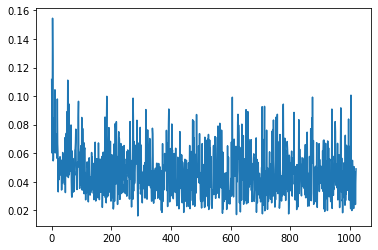

In [17]:
import matplotlib.pyplot as plt
plt.plot(losses[200::20])
plt.show()

In [19]:
gt, image = train_dataset[2]
image = image.unsqueeze(0).to('cuda:0')
image = image.unsqueeze(0)
print(image.shape)
#gt = gt.unsqueeze(0).to('cuda:0')
gt = gt.unsqueeze(0).numpy()
output = network(image)
output = output.squeeze(1).cpu().detach().numpy()
loss = torch.tensor(ssim(gt, output))
loss2 = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
print(loss.item())
print(loss2.item())
#loss2 = mse_loss(output, gt)
len(train_dataset)

torch.Size([1, 1, 320, 320])


RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 5.77 GiB total capacity; 4.90 GiB already allocated; 10.69 MiB free; 22.92 MiB cached)

In [ ]:
e = []
a=[]
b=[]
i = 0
for i in range(0,len(train_dataset)):
    gt, image = train_dataset[i]
    image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    #gt = gt.unsqueeze(0).to('cuda:0')
    gt = gt.unsqueeze(0).numpy()
    output = network(image)
    output = output.squeeze(1).cpu().detach().numpy()
    loss = torch.tensor(ssim(gt, output))
    loss2 = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    e.append(loss.item()-loss2.item())
    a.append(loss.item())

    if loss.item()-loss2.item() < 0:
        i+=1
print(np.nanmean(e))
print(np.nanmean(a))

0.05395069677209438
0.13254272937774658


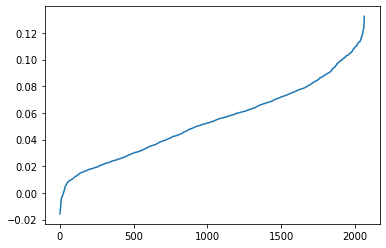

In [42]:
listaaa = []
for i in e:
    #if i < 0:
    listaaa.append(i)
print(np.mean(listaaa))
print((max(listaaa)))
listaaa.sort()
plt.plot(listaaa)

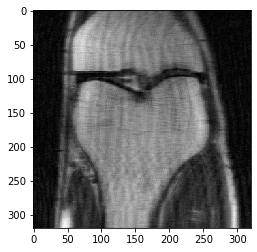

In [37]:

gt, image = train_dataset[e.index(max(e))]
image = image.unsqueeze(0).to('cuda:0')
image = image.unsqueeze(0)
#gt = gt.unsqueeze(0).to('cuda:0')
gt = gt.numpy()
#model.to("cuda:0")
output = model(image)
output = output.squeeze(1).cpu().detach().numpy()
net_out = output.squeeze(0)
plt.imshow(image.squeeze(0).squeeze(0).cpu(), cmap='gray')



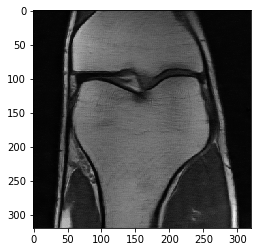

In [38]:
plt.imshow(net_out, cmap='gray')

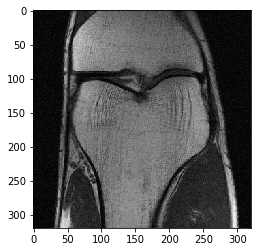

In [39]:
plt.imshow(gt, cmap='gray')

In [ ]:
gt, image = train_dataset[3]
image = image.unsqueeze(0).to('cuda:0')
image = image.unsqueeze(0)
gt = gt.unsqueeze(0).to('cuda:0')
gt = gt.unsqueeze(0)
output = network(image)
loss = mse_loss(output, gt)
loss2 = mse_loss(image, gt)
print(loss.item())
print(loss2.item())

In [12]:
model = ResNet(baseBlock, [2,2,2,2,3,3,3,3,2,2,2,2])
model.load_state_dict(torch.load("/home/students/jaf669/work/GroupProject/bs1_ep10_lr5e-3_bd2-2-2-2-3-3-3-3-2-2-2-2.pt"))
model.train()
#print(model.conv1.weight.data.numpy() == network.cpu().conv1.weight.data.numpy())
#print(network.conv1.weight.data.numpy())

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Ba

In [31]:
e = []
a=[]
b=[]
i = 0
model.to("cuda:0")
for i in range(0,len(train_dataset)):
    gt, image = train_dataset[i]
    image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    #gt = gt.unsqueeze(0).to('cuda:0')
    gt = gt.unsqueeze(0).numpy()
    output = model(image)
    output = output.squeeze(1).cpu().detach().numpy()
    loss = torch.tensor(ssim(gt, output))
    loss2 = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    e.append(loss.item()-loss2.item())
    a.append(loss.item())

    if loss.item()-loss2.item() < 0:
        i+=1
print(np.nanmean(e))
print(np.nanmean(a))

/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


0.05395069677209438
0.6206367444463594


In [17]:
e = []
a=[]
b=[]
i = 0
for i in range(0,3):
    gt, image = train_dataset[i]
    image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    #gt = gt.unsqueeze(0).to('cuda:0')
    gt = gt.unsqueeze(0).numpy()
    model.to("cuda:0")
    output = model(image)
    output = output.squeeze(1).cpu().detach().numpy()
    loss = torch.tensor(ssim(gt, output))
    loss2 = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    e.append(loss.item()-loss2.item())
    a.append(loss.item())

    if loss.item()-loss2.item() < 0:
        i+=1
print(np.nanmean(e))
print(np.nanmean(a))

/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


0.056958526372909546
0.5742055177688599


In [45]:
if __name__ == '__main__':
    
#     data_path_train = '/data/local/NC2019MRI/train'
#     data_path_val = '/data/local/NC2019MRI/train'
#     data_list = load_data_path(data_path_train, data_path_val) # first load all file names, paths and slices.
    
#     acc = 4
#     cen_fract = 0.08
#     seed = False # random masks for each slice 
#     num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
#     lr = 3e-3
    
#     model.to('cuda:0')
#     mse_loss = nn.L1Loss().to('cuda:0')
    
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     fixed_train_set = []
#     for val in data_list['train']:
#         if val[2] > 5:
#             fixed_train_set.append(val)
#     #create data loader for training set. It applies same to validation set as well
#     train_dataset = MRIDataset(fixed_train_set, acceleration=acc, center_fraction=cen_fract, use_seed=seed)
#     train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=num_workers) 
    
    losses=[]
    mean_loss_list = []
    
    for epoch in range(2):
        i = 0
        for iteration, sample in enumerate(train_loader):
            i += 1
            img_gt, img_und = sample
        
            img_gt = img_gt.unsqueeze(1).to('cuda:0')
            img_und = img_und.unsqueeze(1).to('cuda:0')

            output = model(img_und)       #feedforward
            #output = output.squeeze(1).cpu().detach().numpy()

            loss = mse_loss(output, img_gt)
            #loss = torch.tensor(ssim(img_gt, output)).to('cuda:0')
            #print(loss.item())
            optimizer.zero_grad()       #set current gradients to 0
            loss.backward()      #backpropagate
            optimizer.step()     #update the weights
            mean_loss_list.append(loss.item())
            if i%5 == 0:
                print(np.round(np.mean(mean_loss_list), decimals = 5), "  ", i, "  ", epoch+1)
                mean_loss_list = []
            losses.append(loss.item() * img_gt.size(0))
e = []
a=[]
b=[]
i = 0
model.to("cuda:0")
for i in range(0,len(train_dataset)):
    gt, image = train_dataset[i]
    image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    #gt = gt.unsqueeze(0).to('cuda:0')
    gt = gt.unsqueeze(0).numpy()
    output = model(image)
    output = output.squeeze(1).cpu().detach().numpy()
    loss = torch.tensor(ssim(gt, output))
    loss2 = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    e.append(loss.item()-loss2.item())
    a.append(loss.item())

    if loss.item()-loss2.item() < 0:
        i+=1
print(np.nanmean(e))
print(np.nanmean(a))

0.03859    5    1
0.0375    10    1
0.04039    15    1
0.04144    20    1
0.03797    25    1
0.03529    30    1
0.03097    35    1
0.04837    40    1
0.04163    45    1
0.03942    50    1
0.03814    55    1
0.04492    60    1
0.0371    65    1
0.03782    70    1
0.03389    75    1
0.05778    80    1
0.0379    85    1
0.02814    90    1
0.04047    95    1
0.04332    100    1
0.0419    105    1
0.03966    110    1
0.03497    115    1
0.04149    120    1
0.03647    125    1
0.04051    130    1
0.04213    135    1
0.03921    140    1
0.03431    145    1
0.04252    150    1
0.06582    155    1
0.0327    160    1
0.03672    165    1
0.0594    170    1
0.05122    175    1
0.03406    180    1
0.0463    185    1
0.03757    190    1
0.0447    195    1
0.04997    200    1
0.03782    205    1
0.03865    210    1
0.04786    215    1
0.03885    220    1
0.03421    225    1
0.03184    230    1
0.04351    235    1
0.03288    240    1
0.05039    245    1
0.04853    250    1
0.04165    255    1
0.05117 

0.04654    2020    1
0.04666    2025    1
0.0455    2030    1
0.03879    2035    1
0.05125    2040    1
0.04521    2045    1
0.03203    2050    1
0.05559    2055    1
0.03529    2060    1
0.03958    5    2
0.04127    10    2
0.03082    15    2
0.0504    20    2
0.03801    25    2
0.04336    30    2
0.0438    35    2
0.03401    40    2
0.03684    45    2
0.04002    50    2
0.04046    55    2
0.03952    60    2
0.03446    65    2
0.04586    70    2
0.03267    75    2
0.05094    80    2
0.04374    85    2
0.03663    90    2
0.04604    95    2
0.04587    100    2
0.03868    105    2
0.03181    110    2
0.0304    115    2
0.03949    120    2
0.04296    125    2
0.04381    130    2
0.05466    135    2
0.03874    140    2
0.0492    145    2
0.03579    150    2
0.03243    155    2
0.03698    160    2
0.0465    165    2
0.05287    170    2
0.04901    175    2
0.04823    180    2
0.04713    185    2
0.04016    190    2
0.05029    195    2
0.04829    200    2
0.03261    205    2
0.04641    210   

0.03909    1975    2
0.03972    1980    2
0.05699    1985    2
0.04759    1990    2
0.03575    1995    2
0.03669    2000    2
0.03554    2005    2
0.0427    2010    2
0.0329    2015    2
0.03888    2020    2
0.04766    2025    2
0.04677    2030    2
0.03976    2035    2
0.0496    2040    2
0.05015    2045    2
0.04569    2050    2
0.03919    2055    2
0.0481    2060    2


/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


0.050487196542207124
0.6169527398364604


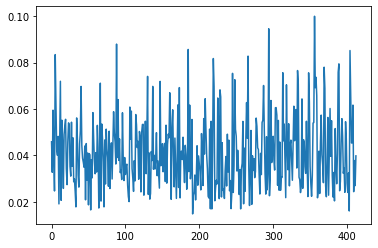

In [46]:
import matplotlib.pyplot as plt
plt.plot(losses[0::10])
plt.show()